forked from https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977

# American Express - Default Prediction   

<今回のデータ>  
submission : 924,621 rows  
train_labels : 458,914 rows   
df_train : 5,531,451 rows × 190 columns  
df_test : 11,363,762 rows

In [4]:
# あらゆるモデルをインポートしとく
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, plot_roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder

import lightgbm as lgb

from tqdm.auto import tqdm # 処理状況の可視化
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

path = "C:/Users/Victor/Documents/My_documents/Kaggle/Amex-Default-Prediction/"

# Preprocessing

In [5]:
# データの読み込みと圧縮、整形

def read_preprocess_data(data, n): # n：データ読み込み時の分割数
    
    if data == 'train':
        file_name = 'train_data.csv'
    elif data == 'test':
        file_name = 'test_data.csv'
    else:
        print('input train or test in string')
    
    # 特徴量（列）を数値データとカテゴリーデータで分類
    temp = pd.read_csv(path + 'test_data.csv', nrows=10)
    features = temp.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list() # S_2：日にち
    cat_features = [
        "B_30", "B_38", "D_114", "D_116", "D_117", "D_120",
        "D_126", "D_63", "D_64", "D_66", "D_68"]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    
    # 数値型列それぞれをIDに関し'mean','std','min','max','last'で集約（俺は最初平均しか使わなかった）
    # float64の列をn分割して読み込み、それぞれ順番にfloat32に変換し結合
    train_num_agg = pd.read_csv(path + file_name, usecols=['customer_ID'])
    for i in tqdm(range(n)):
        train_num_agg_temp = pd.read_csv(path + file_name, usecols=list(np.array_split(num_features, n)[i]))
        train_num_agg_temp = train_num_agg_temp.fillna(99).astype('float32')
        train_num_agg = pd.concat([train_num_agg, train_num_agg_temp], axis=1)
        del train_num_agg_temp # メモリの確保
    train_num_agg = train_num_agg.groupby("customer_ID").agg(['mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns] # 列名の生成
    train_num_agg.reset_index(inplace = True)
    
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    
    # object型列それぞれをIDに関し'count'(購買回数, ほぼ１３), 'last', 'nunique'(カテゴリーの種類)で集約
    train_cat_agg = pd.read_csv(path + file_name, usecols=(['customer_ID'] + cat_features))
    train_cat_agg = train_cat_agg.groupby("customer_ID").agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
        
    # Transform int64 columns to int32（おれはint8にした）
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int8)
        
    new_data = pd.merge(train_num_agg, train_cat_agg, on='customer_ID')
        
    return new_data

In [6]:
train_new = read_preprocess_data('train', 1)
train_new

Starting training feature engineer...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_std,B_1_min,B_1_max,B_1_last,B_2_mean,B_2_std,B_2_min,B_2_max,B_2_last,R_1_mean,R_1_std,R_1_min,R_1_max,R_1_last,S_3_mean,S_3_std,S_3_min,S_3_max,S_3_last,D_41_mean,D_41_std,D_41_min,D_41_max,D_41_last,B_3_mean,B_3_std,B_3_min,B_3_max,B_3_last,D_42_mean,D_42_std,D_42_min,D_42_max,D_42_last,D_43_mean,D_43_std,D_43_min,D_43_max,D_43_last,D_44_mean,D_44_std,D_44_min,D_44_max,D_44_last,B_4_mean,B_4_std,B_4_min,B_4_max,B_4_last,D_45_mean,D_45_std,D_45_min,D_45_max,D_45_last,B_5_mean,B_5_std,B_5_min,B_5_max,B_5_last,R_2_mean,R_2_std,R_2_min,R_2_max,R_2_last,D_46_mean,D_46_std,D_46_min,D_46_max,D_46_last,D_47_mean,D_47_std,D_47_min,D_47_max,D_47_last,D_48_mean,D_48_std,D_48_min,D_48_max,D_48_last,D_49_mean,D_49_std,D_49_min,D_49_max,D_49_last,B_6_mean,B_6_std,B_6_min,B_6_max,B_6_last,B_7_mean,B_7_std,B_7_min,B_7_max,B_7_last,B_8_mean,B_8_std,B_8_min,B_8_max,B_8_last,D_50_mean,D_50_std,D_50_min,D_50_max,D_50_last,D_51_mean,D_51_std,D_51_min,D_51_max,D_51_last,B_9_mean,B_9_std,B_9_min,B_9_max,B_9_last,R_3_mean,R_3_std,R_3_min,R_3_max,R_3_last,D_52_mean,D_52_std,D_52_min,D_52_max,D_52_last,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,B_10_mean,B_10_std,B_10_min,B_10_max,B_10_last,D_53_mean,D_53_std,D_53_min,D_53_max,D_53_last,S_5_mean,S_5_std,S_5_min,S_5_max,S_5_last,B_11_mean,B_11_std,B_11_min,B_11_max,B_11_last,S_6_mean,S_6_std,S_6_min,S_6_max,S_6_last,D_54_mean,D_54_std,D_54_min,D_54_max,D_54_last,R_4_mean,R_4_std,R_4_min,R_4_max,R_4_last,S_7_mean,S_7_std,S_7_min,S_7_max,S_7_last,B_12_mean,B_12_std,B_12_min,B_12_max,B_12_last,S_8_mean,S_8_std,S_8_min,S_8_max,S_8_last,D_55_mean,D_55_std,D_55_min,D_55_max,D_55_last,D_56_mean,D_56_std,D_56_min,D_56_max,D_56_last,B_13_mean,B_13_std,B_13_min,B_13_max,B_13_last,R_5_mean,R_5_std,R_5_min,R_5_max,R_5_last,D_58_mean,D_58_std,D_58_min,D_58_max,D_58_last,S_9_mean,S_9_std,S_9_min,S_9_max,S_9_last,B_14_mean,B_14_std,B_14_min,B_14_max,B_14_last,D_59_mean,D_59_std,D_59_min,D_59_max,D_59_last,D_60_mean,D_60_std,D_60_min,D_60_max,D_60_last,D_61_mean,D_61_std,D_61_min,D_61_max,D_61_last,B_15_mean,B_15_std,B_15_min,B_15_max,B_15_last,S_11_mean,S_11_std,S_11_min,S_11_max,...,D_107_max,D_107_last,B_36_mean,B_36_std,B_36_min,B_36_max,B_36_last,B_37_mean,B_37_std,B_37_min,B_37_max,B_37_last,R_26_mean,R_26_std,R_26_min,R_26_max,R_26_last,R_27_mean,R_27_std,R_27_min,R_27_max,R_27_last,D_108_mean,D_108_std,D_108_min,D_108_max,D_108_last,D_109_mean,D_109_std,D_109_min,D_109_max,D_109_last,D_110_mean,D_110_std,D_110_min,D_110_max,D_110_last,D_111_mean,D_111_std,D_111_min,D_111_max,D_111_last,B_39_mean,B_39_std,B_39_min,B_39_max,B_39_last,D_112_mean,D_112_std,D_112_min,D_112_max,D_112_last,B_40_mean,B_40_std,B_40_min,B_40_max,B_40_last,S_27_mean,S_27_std,S_27_min,S_27_max,S_27_last,D_113_mean,D_113_std,D_113_min,D_113_max,D_113_last,D_115_mean,D_115_std,D_115_min,D_115_max,D_115_last,D_118_mean,D_118_std,D_118_min,D_118_max,D_118_last,D_119_mean,D_119_std,D_119_min,D_119_max,D_119_last,D_121_mean,D_121_std,D_121_min,D_121_max,D_121_last,D_122_mean,D_122_std,D_122_min,D_122_max,D_122_last,D_123_mean,D_123_std,D_123_min,D_123_max,D_123_last,D_124_mean,D_124_std,D_124_min,D_124_max,D_124_last,D_125_mean,D_125_std,D_125_min,D_125_max,D_125_last,D_127_mean,D_127_std,D_127_min,D_127_max,D_127_last,D_128_mean,D_128_std,D_128_min,D_128_max,D_128_last,D_129_mean,D_129_std,D_129_min,D_129_max,D_129_last,B_41_mean,B_41_std,B_41_min,B_41_max,B_41_last,B_42_mean,B_42_std,B_42_min,B_42_max,B_42_last,D_130_mean,D_130_std,D_130_min,D_130_max,D_130_last,D_131_mean,D_131_std,D_131_min,D_131_max,D_131_last,D_132_mean,D_132_std,D_132_min,D_132_max,D_132_last,D_133_mean,D_133_std,D_133_min,D_133_max,D_133_last,R_28_mean,R_28_std,R_28_min,R_28_max,R_28_last,D_134_mean,D_134_std,D_134_min,D_134_max,D_134_last,D_135_mean,D_135_std,D_135_min,D_135_max,D_135_last,D_136_mean,D_136_std,D_136_min,D_136_max,D_136_last,D_137_mean,D_1

# Training & Inference for train data

In [7]:
# 説明変数、目的変数の設定
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df2 = train_new.drop(['customer_ID', 'D_63_last', 'D_64_last'], axis=1)
del train_new

labels = pd.read_csv(path + 'train_labels.csv')

X = df2.values
# y = df2.iloc[:len(df2), -1].values
y = labels.iloc[:len(df2), -1].values
# X_test = df.iloc[len(df_train):, 1:].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
del df2

In [8]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import re
# df2 = df2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # 変なエラー解決するため入れた

# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train) 

# パラメータ
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 分類
        'metric': {'auc'}, # 評価指標かな？
        'num_leaves': 20,             
        'max_depth':5,
        'min_data_in_leaf': 3,        
        'num_iteration': 100,            
        'learning_rate':0.03,
        'num_boost_round':100,
        'early_stopping_rounds':20, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

[LightGBM] [Info] Number of positive: 83180, number of negative: 238059
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.769637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222975
[LightGBM] [Info] Number of data points in the train set: 321239, number of used features: 915
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258935 -> initscore=-1.051512
[LightGBM] [Info] Start training from score -1.051512
[1]	valid_0's auc: 0.927182
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.93047
[3]	valid_0's auc: 0.931466
[4]	valid_0's auc: 0.934837
[5]	valid_0's auc: 0.935139
[6]	valid_0's auc: 0.935541
[7]	valid_0's auc: 0.936259
[8]	valid_0's auc: 0.936731
[9]	valid_0's auc: 0.937652
[10]	valid_0's auc: 0.937955
[11]	valid_0's auc: 0.938932
[12]	valid_0's auc: 0.939078
[13]	valid_0's auc: 0.939292
[14]	valid_0's auc: 0.939537
[15]	valid_0's auc: 0.94054
[16]	valid_0'

In [9]:
# LGBMClassifier
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)
lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

# XGBClassifier
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, xgb_valid_pred)}")

# アンサンブル
train_pred = (lgb_train_pred + xgb_train_pred)/2
valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)}")

Train Score: 0.9641235265375028
Valid Score: 0.9599914410545931
Train Score: 0.9777241620808013
Valid Score: 0.9587911143911517
Train Score: 0.9728450826503363
Valid Score: 0.9604928838764336


In [12]:
def threshold_accuracy(y_pred):
    
    from sklearn.metrics import accuracy_score
    
    lis_acc = []
    for j in range(100):
        pred_acc = []
        for i in range(len(y_pred)):
            if y_pred[i]>=j/100:
                pred_acc.append(1)
            else:
                pred_acc.append(0)
        lis_acc.append(accuracy_score(y_valid, pred_acc))
        # print(j, accuracy_score(y_valid, pred_acc))

    print('正解率', max(lis_acc), '　閾値：', lis_acc.index(max(lis_acc)))

    plt.xlabel("threshold")
    plt.ylabel("accuracy")
    plt.plot(lis_acc)
    plt.show()

正解率 0.9016880456731119 　閾値： 50


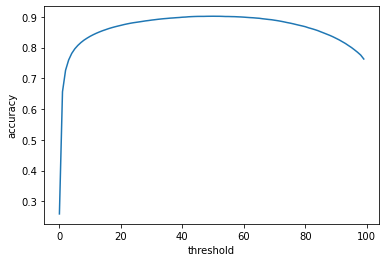

正解率 0.8923035576797362 　閾値： 50


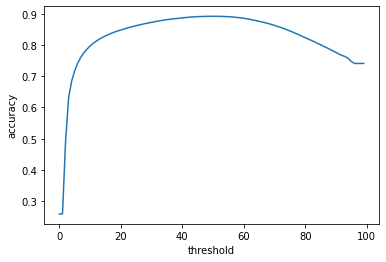

In [13]:
threshold_accuracy(valid_pred)
threshold_accuracy(y_pred)

In [ ]:
cat_features = [
        "B_30", "B_38", "D_114", "D_116", "D_117", "D_120",
        "D_126", "D_63", "D_64", "D_66", "D_68"]

# Training & Inference for test data

In [12]:
test_new = read_preprocess_data('test', 50)

Starting training feature engineer...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [19]:
print(test_new.shape)
test_new.head()

(924621, 919)


,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_std,B_1_min,B_1_max,B_1_last,B_2_mean,B_2_std,B_2_min,B_2_max,B_2_last,R_1_mean,R_1_std,R_1_min,R_1_max,R_1_last,S_3_mean,S_3_std,S_3_min,S_3_max,S_3_last,D_41_mean,D_41_std,D_41_min,D_41_max,D_41_last,B_3_mean,B_3_std,B_3_min,B_3_max,B_3_last,D_42_mean,D_42_std,D_42_min,D_42_max,D_42_last,D_43_mean,D_43_std,D_43_min,D_43_max,D_43_last,D_44_mean,D_44_std,D_44_min,D_44_max,D_44_last,B_4_mean,B_4_std,B_4_min,B_4_max,B_4_last,D_45_mean,D_45_std,D_45_min,D_45_max,D_45_last,B_5_mean,B_5_std,B_5_min,B_5_max,B_5_last,R_2_mean,R_2_std,R_2_min,R_2_max,R_2_last,D_46_mean,D_46_std,D_46_min,D_46_max,D_46_last,D_47_mean,D_47_std,D_47_min,D_47_max,D_47_last,D_48_mean,D_48_std,D_48_min,D_48_max,D_48_last,D_49_mean,D_49_std,D_49_min,D_49_max,D_49_last,B_6_mean,B_6_std,B_6_min,B_6_max,B_6_last,B_7_mean,B_7_std,B_7_min,B_7_max,B_7_last,B_8_mean,B_8_std,B_8_min,B_8_max,B_8_last,D_50_mean,D_50_std,D_50_min,D_50_max,D_50_last,D_51_mean,D_51_std,D_51_min,D_51_max,D_51_last,B_9_mean,B_9_std,B_9_min,B_9_max,B_9_last,R_3_mean,R_3_std,R_3_min,R_3_max,R_3_last,D_52_mean,D_52_std,D_52_min,D_52_max,D_52_last,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,B_10_mean,B_10_std,B_10_min,B_10_max,B_10_last,D_53_mean,D_53_std,D_53_min,D_53_max,D_53_last,S_5_mean,S_5_std,S_5_min,S_5_max,S_5_last,B_11_mean,B_11_std,B_11_min,B_11_max,B_11_last,S_6_mean,S_6_std,S_6_min,S_6_max,S_6_last,D_54_mean,D_54_std,D_54_min,D_54_max,D_54_last,R_4_mean,R_4_std,R_4_min,R_4_max,R_4_last,S_7_mean,S_7_std,S_7_min,S_7_max,S_7_last,B_12_mean,B_12_std,B_12_min,B_12_max,B_12_last,S_8_mean,S_8_std,S_8_min,S_8_max,S_8_last,D_55_mean,D_55_std,D_55_min,D_55_max,D_55_last,D_56_mean,D_56_std,D_56_min,D_56_max,D_56_last,B_13_mean,B_13_std,B_13_min,B_13_max,B_13_last,R_5_mean,R_5_std,R_5_min,R_5_max,R_5_last,D_58_mean,D_58_std,D_58_min,D_58_max,D_58_last,S_9_mean,S_9_std,S_9_min,S_9_max,S_9_last,B_14_mean,B_14_std,B_14_min,B_14_max,B_14_last,D_59_mean,D_59_std,D_59_min,D_59_max,D_59_last,D_60_mean,D_60_std,D_60_min,D_60_max,D_60_last,D_61_mean,D_61_std,D_61_min,D_61_max,D_61_last,B_15_mean,B_15_std,B_15_min,B_15_max,B_15_last,S_11_mean,S_11_std,S_11_min,S_11_max,...,D_107_max,D_107_last,B_36_mean,B_36_std,B_36_min,B_36_max,B_36_last,B_37_mean,B_37_std,B_37_min,B_37_max,B_37_last,R_26_mean,R_26_std,R_26_min,R_26_max,R_26_last,R_27_mean,R_27_std,R_27_min,R_27_max,R_27_last,D_108_mean,D_108_std,D_108_min,D_108_max,D_108_last,D_109_mean,D_109_std,D_109_min,D_109_max,D_109_last,D_110_mean,D_110_std,D_110_min,D_110_max,D_110_last,D_111_mean,D_111_std,D_111_min,D_111_max,D_111_last,B_39_mean,B_39_std,B_39_min,B_39_max,B_39_last,D_112_mean,D_112_std,D_112_min,D_112_max,D_112_last,B_40_mean,B_40_std,B_40_min,B_40_max,B_40_last,S_27_mean,S_27_std,S_27_min,S_27_max,S_27_last,D_113_mean,D_113_std,D_113_min,D_113_max,D_113_last,D_115_mean,D_115_std,D_115_min,D_115_max,D_115_last,D_118_mean,D_118_std,D_118_min,D_118_max,D_118_last,D_119_mean,D_119_std,D_119_min,D_119_max,D_119_last,D_121_mean,D_121_std,D_121_min,D_121_max,D_121_last,D_122_mean,D_122_std,D_122_min,D_122_max,D_122_last,D_123_mean,D_123_std,D_123_min,D_123_max,D_123_last,D_124_mean,D_124_std,D_124_min,D_124_max,D_124_last,D_125_mean,D_125_std,D_125_min,D_125_max,D_125_last,D_127_mean,D_127_std,D_127_min,D_127_max,D_127_last,D_128_mean,D_128_std,D_128_min,D_128_max,D_128_last,D_129_mean,D_129_std,D_129_min,D_129_max,D_129_last,B_41_mean,B_41_std,B_41_min,B_41_max,B_41_last,B_42_mean,B_42_std,B_42_min,B_42_max,B_42_last,D_130_mean,D_130_std,D_130_min,D_130_max,D_130_last,D_131_mean,D_131_std,D_131_min,D_131_max,D_131_last,D_132_mean,D_132_std,D_132_min,D_132_max,D_132_last,D_133_mean,D_133_std,D_133_min,D_133_max,D_133_last,R_28_mean,R_28_std,R_28_min,R_28_max,R_28_last,D_134_mean,D_134_std,D_134_min,D_134_max,D_134_last,D_135_mean,D_135_std,D_135_min,D_135_max,D_135_last,D_136_mean,D_136_std,D_136_min,D_136_max,D_136_last,D_137_mean,D_1

In [18]:
print(train_new.shape)
train_new.head()

(458913, 919)


,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_std,B_1_min,B_1_max,B_1_last,B_2_mean,B_2_std,B_2_min,B_2_max,B_2_last,R_1_mean,R_1_std,R_1_min,R_1_max,R_1_last,S_3_mean,S_3_std,S_3_min,S_3_max,S_3_last,D_41_mean,D_41_std,D_41_min,D_41_max,D_41_last,B_3_mean,B_3_std,B_3_min,B_3_max,B_3_last,D_42_mean,D_42_std,D_42_min,D_42_max,D_42_last,D_43_mean,D_43_std,D_43_min,D_43_max,D_43_last,D_44_mean,D_44_std,D_44_min,D_44_max,D_44_last,B_4_mean,B_4_std,B_4_min,B_4_max,B_4_last,D_45_mean,D_45_std,D_45_min,D_45_max,D_45_last,B_5_mean,B_5_std,B_5_min,B_5_max,B_5_last,R_2_mean,R_2_std,R_2_min,R_2_max,R_2_last,D_46_mean,D_46_std,D_46_min,D_46_max,D_46_last,D_47_mean,D_47_std,D_47_min,D_47_max,D_47_last,D_48_mean,D_48_std,D_48_min,D_48_max,D_48_last,D_49_mean,D_49_std,D_49_min,D_49_max,D_49_last,B_6_mean,B_6_std,B_6_min,B_6_max,B_6_last,B_7_mean,B_7_std,B_7_min,B_7_max,B_7_last,B_8_mean,B_8_std,B_8_min,B_8_max,B_8_last,D_50_mean,D_50_std,D_50_min,D_50_max,D_50_last,D_51_mean,D_51_std,D_51_min,D_51_max,D_51_last,B_9_mean,B_9_std,B_9_min,B_9_max,B_9_last,R_3_mean,R_3_std,R_3_min,R_3_max,R_3_last,D_52_mean,D_52_std,D_52_min,D_52_max,D_52_last,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,B_10_mean,B_10_std,B_10_min,B_10_max,B_10_last,D_53_mean,D_53_std,D_53_min,D_53_max,D_53_last,S_5_mean,S_5_std,S_5_min,S_5_max,S_5_last,B_11_mean,B_11_std,B_11_min,B_11_max,B_11_last,S_6_mean,S_6_std,S_6_min,S_6_max,S_6_last,D_54_mean,D_54_std,D_54_min,D_54_max,D_54_last,R_4_mean,R_4_std,R_4_min,R_4_max,R_4_last,S_7_mean,S_7_std,S_7_min,S_7_max,S_7_last,B_12_mean,B_12_std,B_12_min,B_12_max,B_12_last,S_8_mean,S_8_std,S_8_min,S_8_max,S_8_last,D_55_mean,D_55_std,D_55_min,D_55_max,D_55_last,D_56_mean,D_56_std,D_56_min,D_56_max,D_56_last,B_13_mean,B_13_std,B_13_min,B_13_max,B_13_last,R_5_mean,R_5_std,R_5_min,R_5_max,R_5_last,D_58_mean,D_58_std,D_58_min,D_58_max,D_58_last,S_9_mean,S_9_std,S_9_min,S_9_max,S_9_last,B_14_mean,B_14_std,B_14_min,B_14_max,B_14_last,D_59_mean,D_59_std,D_59_min,D_59_max,D_59_last,D_60_mean,D_60_std,D_60_min,D_60_max,D_60_last,D_61_mean,D_61_std,D_61_min,D_61_max,D_61_last,B_15_mean,B_15_std,B_15_min,B_15_max,B_15_last,S_11_mean,S_11_std,S_11_min,S_11_max,...,D_107_max,D_107_last,B_36_mean,B_36_std,B_36_min,B_36_max,B_36_last,B_37_mean,B_37_std,B_37_min,B_37_max,B_37_last,R_26_mean,R_26_std,R_26_min,R_26_max,R_26_last,R_27_mean,R_27_std,R_27_min,R_27_max,R_27_last,D_108_mean,D_108_std,D_108_min,D_108_max,D_108_last,D_109_mean,D_109_std,D_109_min,D_109_max,D_109_last,D_110_mean,D_110_std,D_110_min,D_110_max,D_110_last,D_111_mean,D_111_std,D_111_min,D_111_max,D_111_last,B_39_mean,B_39_std,B_39_min,B_39_max,B_39_last,D_112_mean,D_112_std,D_112_min,D_112_max,D_112_last,B_40_mean,B_40_std,B_40_min,B_40_max,B_40_last,S_27_mean,S_27_std,S_27_min,S_27_max,S_27_last,D_113_mean,D_113_std,D_113_min,D_113_max,D_113_last,D_115_mean,D_115_std,D_115_min,D_115_max,D_115_last,D_118_mean,D_118_std,D_118_min,D_118_max,D_118_last,D_119_mean,D_119_std,D_119_min,D_119_max,D_119_last,D_121_mean,D_121_std,D_121_min,D_121_max,D_121_last,D_122_mean,D_122_std,D_122_min,D_122_max,D_122_last,D_123_mean,D_123_std,D_123_min,D_123_max,D_123_last,D_124_mean,D_124_std,D_124_min,D_124_max,D_124_last,D_125_mean,D_125_std,D_125_min,D_125_max,D_125_last,D_127_mean,D_127_std,D_127_min,D_127_max,D_127_last,D_128_mean,D_128_std,D_128_min,D_128_max,D_128_last,D_129_mean,D_129_std,D_129_min,D_129_max,D_129_last,B_41_mean,B_41_std,B_41_min,B_41_max,B_41_last,B_42_mean,B_42_std,B_42_min,B_42_max,B_42_last,D_130_mean,D_130_std,D_130_min,D_130_max,D_130_last,D_131_mean,D_131_std,D_131_min,D_131_max,D_131_last,D_132_mean,D_132_std,D_132_min,D_132_max,D_132_last,D_133_mean,D_133_std,D_133_min,D_133_max,D_133_last,R_28_mean,R_28_std,R_28_min,R_28_max,R_28_last,D_134_mean,D_134_std,D_134_min,D_134_max,D_134_last,D_135_mean,D_135_std,D_135_min,D_135_max,D_135_last,D_136_mean,D_136_std,D_136_min,D_136_max,D_136_last,D_137_mean,D_1

In [13]:
# テストデータに対する予測値の作成
test_new = test_new.drop(['customer_ID', 'D_63_last', 'D_64_last'], axis=1)
test_new = test_new.values

# pred = lgb.predict_proba(X_test)[:, 1]
pred_test = (lgb.predict_proba(test_new)[:, 1] + xgb.predict_proba(test_new)[:, 1]) / 2

(array([554908.,  49475.,  34370.,  29622.,  28391.,  29075.,  31435.,
         36550.,  45582.,  85213.]),
 array([4.39038233e-04, 1.00301398e-01, 2.00163757e-01, 3.00026117e-01,
        3.99888476e-01, 4.99750836e-01, 5.99613195e-01, 6.99475555e-01,
        7.99337914e-01, 8.99200274e-01, 9.99062633e-01]),
 <BarContainer object of 10 artists>)

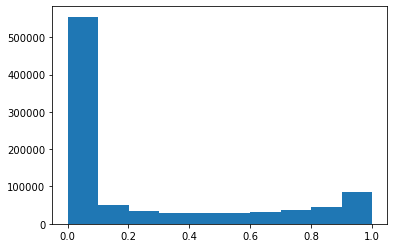

In [16]:
plt.hist(pred_test)

In [18]:
# 予測結果を提出用のフォーマットに格納
submission2 = pd.read_csv(path + 'sample_submission.csv')
submission2['prediction'] = np.array(pred_test)

# 提出用のcsvファイルを作成
submission2.to_csv('C:/Users/Victor/Documents/my_study/Kaggle/Amex-Default-Prediction/submission2.csv', index=False)
submission2

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.043849
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001472
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.098811
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.231457
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.856216
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.025055
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.770490
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.416019
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.356991


# メモリ確認

In [16]:
del df2

In [3]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                DataFrame|      1064|
|             GridSearchCV|      1064|
|                       In|        96|
|             LabelEncoder|      1064|
|            OneHotEncoder|      1064|
|           OrdinalEncoder|      1064|
|                      Out|       232|
|            SGDClassifier|      1064|
|                   Series|      1064|
|           StandardScaler|      1064|
|                      auc|       136|
|    classification_report|       136|
|                     exit|        48|
|              get_ipython|        64|
|                      lgb|        72|
|                       np|        72|
|                     path|       115|
|                       pd|        72|
|    plot_confusion_matrix|       136|
|           plot_roc_curve|       136|
|                      plt|        72|
|   precision_recall_curve|       136|
|                     quit|        48|
|                roc_curv